In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime ,time 
import time
import plotly.express as px

## import csv

In [121]:
uber = pd.read_csv("../uber-ride-exploratory-data-analysis/uber_n.csv")

In [122]:
uber.shape

(3356, 1)

In [123]:
uber.head(10)

,data
0,11-Aug-22
1,9:16 PM
2,"NGN 3,368.00"
3,Lagos
4,25.53 Kilometers
5,UberX
6,"1 Ligali Ayorinde St, Eti-Osa 106104, Lagos, N..."
7,"Ifako/Soluyi, Lagos, Nigeria"
8,1-Aug-22
9,12:19 PM


In [124]:
year_check = []
for i in uber.data:
    if i.endswith("-16"):
        year_check.append('2016')
    elif i.endswith("-17"):
        year_check.append('2017')
    elif i.endswith("-18"):
        year_check.append('2018')
    elif i.endswith("-19"):
        year_check.append('2019')
    elif i.endswith("-20"):
        year_check.append('2020')
    elif i.endswith("-21"):
        year_check.append('2021')
    elif i.endswith("-22"):
        year_check.append('2022')
    else:
        year_check.append('none')

In [125]:
ride_year = pd.DataFrame(year_check).rename({0:'year'}, axis =1)

In [126]:
ride_year = ride_year [ride_year.year !='none']

In [127]:
ride_year.value_counts()

year
2019    132
2021    123
2020     65
2022     64
2017     40
2018      9
2016      2
dtype: int64

In [128]:
uber['year'] = ride_year

## Drop NaNs

## Search and extract rows for time using the 'AM' and 'PM' strings

In [129]:
uber_t =uber[uber.data.str.contains(' PM') | uber.data.str.contains(' AM')]
uber_t

,data,year
1,9:16 PM,NaN
9,12:19 PM,NaN
16,11:03 AM,NaN
24,10:01 PM,NaN
32,9:53 PM,NaN
...,...,...
3321,7:01 AM,NaN
3329,3:44 PM,NaN
3337,12:48 PM,NaN
3345,10:33 AM,NaN


## using the .split() method to extract AM and PM from time.

In [130]:
uber_t = uber_t.data.str.split(expand = True).rename({0: "time",1:'am_pm'},axis=1)

In [131]:
uber_t[:4]

,time,am_pm
1,9:16,PM
9,12:19,PM
16,11:03,AM
24,10:01,PM


## convert to datetime

In [132]:
uber_t['time'] = pd.DatetimeIndex(uber_t.time)
uber_t['tod(hr)'] = pd.DatetimeIndex(uber_t.time).hour
uber_t.head(3)

,time,am_pm,tod(hr)
1,2022-10-24 09:16:00,PM,9
9,2022-10-24 12:19:00,PM,12
16,2022-10-24 11:03:00,AM,11


# lets classifiy the time into "morning", "afternoon", "evening", "night

In [133]:
def func_tod(x):
    if (x>=0) & (x<6):
        tod = 'night'
    elif (x>=6) & (x<12):
        tod = 'morning'
    elif (x>=12) & (x<18):
        tod = 'afternoon'
    else:
        tod = 'evening'
    return tod

In [134]:
uber_t['tod_class'] = uber_t['tod(hr)'].apply(lambda x: func_tod(x))

In [135]:
uber_t.sample(5)

,time,am_pm,tod(hr),tod_class
890,2022-10-24 01:52:00,PM,1,night
992,2022-10-24 12:53:00,PM,12,afternoon
1592,2022-10-24 11:17:00,AM,11,morning
118,2022-10-24 08:08:00,PM,8,morning
281,2022-10-24 04:46:00,AM,4,night


## feature extraction for price using the NGN (Nigerian currency)

In [136]:
uber['price'] = uber['data'].str.contains('NGN')

In [137]:
uber_price = uber[uber.price == True]

In [138]:
uber_price = uber_price.drop('price',axis =1).rename({"data":"price"},axis =1)
uber_price.head()

,price,year
2,"NGN 3,368.00",NaN
10,NGN 0.00,NaN
17,"NGN 1,600.00",NaN
25,"NGN 1,000.00",NaN
33,NGN 0.00,NaN


## using the regex and .split() method to extract the NGN , comma and period

In [139]:
stripped_price = uber_price.price.str.replace(r"\,","").str.replace(r"\.00","")

C:\Users\godwi\AppData\Local\Temp\ipykernel_15456\4112769728.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [140]:
stripped_price= stripped_price.str.split(expand=True)[1]

In [141]:
stripped_price

2       3368
10         0
17      1600
25      1000
33         0
        ... 
3322       0
3330    2300
3338       0
3346       0
3352       0
Name: 1, Length: 433, dtype: object

## Feature extraction for rows with distance using the Kilometers.

In [142]:
uber['distance'] = uber['data'].str.contains('Kilometers')

In [143]:
uber_distance = uber[uber.distance == True]

In [144]:
uber_distance = uber_distance.drop(['price','distance'],axis =1)

In [145]:
uber_distance =uber_distance.rename({"data":"distance"},axis=1)
uber_distance.head()

,distance,year
4,25.53 Kilometers,NaN
12,0.00 Kilometers,NaN
19,11.11 Kilometers,NaN
27,3.43 Kilometers,NaN
35,0.00 Kilometers,NaN


## using the .split() method to extract distance using the tag "distance"

In [146]:
ride_distance = uber_distance.distance.str.split(expand = True, n= 2)[0]
ride_distance

4       25.53
12       0.00
19      11.11
27       3.43
35       0.00
        ...  
3324     0.00
3332    18.01
3340     0.00
3348     0.00
3354     0.00
Name: 0, Length: 433, dtype: object

## Concat both price , distance, time dataframes, also reseting index - so they are common

In [147]:
rides =pd.concat([stripped_price.reset_index(), ride_distance.reset_index(),uber_t.reset_index()],axis = 1,join='outer')\
    .reset_index().drop(['index','level_0'], axis =1).rename({1:"price", 0:'distance'},axis =1)
rides

,price,distance,time,am_pm,tod(hr),tod_class
0,3368,25.53,2022-10-24 09:16:00,PM,9,morning
1,0,0.00,2022-10-24 12:19:00,PM,12,afternoon
2,1600,11.11,2022-10-24 11:03:00,AM,11,morning
3,1000,3.43,2022-10-24 10:01:00,PM,10,morning
4,0,0.00,2022-10-24 09:53:00,PM,9,morning
...,...,...,...,...,...,...
430,0,0.00,2022-10-24 07:01:00,AM,7,morning
431,0,0.00,2022-10-24 03:44:00,PM,3,night
432,0,0.00,2022-10-24 12:48:00,PM,12,afternoon
433,NaN,NaN,2022-10-24 10:33:00,AM,10,morning


## change the data types

In [148]:
rides = rides.astype({'price' : 'float','distance':'float' })
rides.dtypes

price               float64
distance            float64
time         datetime64[ns]
am_pm                object
tod(hr)               int64
tod_class            object
dtype: object

# Final data frame

In [149]:
rides

,price,distance,time,am_pm,tod(hr),tod_class
0,3368.0,25.53,2022-10-24 09:16:00,PM,9,morning
1,0.0,0.00,2022-10-24 12:19:00,PM,12,afternoon
2,1600.0,11.11,2022-10-24 11:03:00,AM,11,morning
3,1000.0,3.43,2022-10-24 10:01:00,PM,10,morning
4,0.0,0.00,2022-10-24 09:53:00,PM,9,morning
...,...,...,...,...,...,...
430,0.0,0.00,2022-10-24 07:01:00,AM,7,morning
431,0.0,0.00,2022-10-24 03:44:00,PM,3,night
432,0.0,0.00,2022-10-24 12:48:00,PM,12,afternoon
433,NaN,NaN,2022-10-24 10:33:00,AM,10,morning


In [150]:
rides = pd.concat([rides.reset_index(),ride_year.year.reset_index()],axis =1)

In [151]:
rides.drop('index', axis=1, inplace=True)

In [152]:
cc = []
for i in rides.price :
    if i > 0:
        cc.append('completed')
    else:
        cc.append('cancelled')

In [153]:
rides['completed vs cancelled'] = cc

In [154]:
rides

,price,distance,time,am_pm,tod(hr),tod_class,year,completed vs cancelled
0,3368.0,25.53,2022-10-24 09:16:00,PM,9,morning,2022,completed
1,0.0,0.00,2022-10-24 12:19:00,PM,12,afternoon,2022,cancelled
2,1600.0,11.11,2022-10-24 11:03:00,AM,11,morning,2022,completed
3,1000.0,3.43,2022-10-24 10:01:00,PM,10,morning,2022,completed
4,0.0,0.00,2022-10-24 09:53:00,PM,9,morning,2022,cancelled
...,...,...,...,...,...,...,...,...
430,0.0,0.00,2022-10-24 07:01:00,AM,7,morning,2017,cancelled
431,0.0,0.00,2022-10-24 03:44:00,PM,3,night,2017,cancelled
432,0.0,0.00,2022-10-24 12:48:00,PM,12,afternoon,2017,cancelled
433,NaN,NaN,2022-10-24 10:33:00,AM,10,morning,2016,cancelled


## Perform Statistics description of both price and distance

In [155]:
rides.describe()

,price,distance,tod(hr)
count,433.000000,433.000000,435.000000
mean,742.939954,5.938845,6.374713
std,988.162256,8.235563,3.489260
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,6.000000
75%,1400.000000,11.490000,9.000000
max,5600.000000,43.500000,12.000000


In [156]:
rides.to_excel('uber_ride_clean.xlsx', index = False)

## How many completed uber trips ie not equal to zero km

In [157]:
rides[rides.price != 0].value_counts().sum()

208

c:\Users\godwi\anaconda3\envs\ML\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='price', ylabel='distance'>

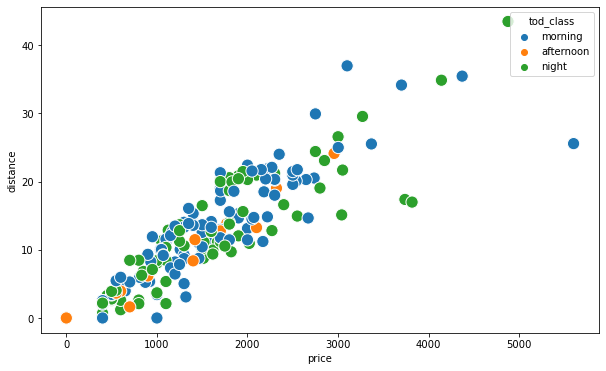

In [158]:
fig,ax =plt.subplots(figsize = (10,6))
sns.scatterplot(rides.price, rides.distance,ax=ax, s = 150,  hue = rides.tod_class)

# what time of the day was most trip

In [159]:
fig=px.bar(rides.tod_class, orientation='h' )
fig.update_layout(width=700)
fig.show()

c:\Users\godwi\anaconda3\envs\ML\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='tod_class', ylabel='count'>

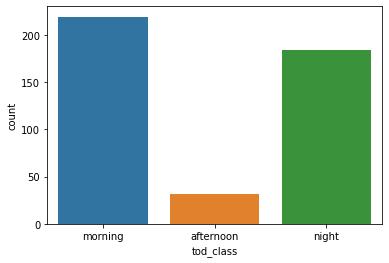

In [160]:
sns.countplot(rides.tod_class, )

In [161]:
print("thank you")

thank you


# The data is very linear, but I wish to play around with clustering . You might ignore

In [162]:
# label encode the day of week
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [163]:
rides['tod_class_encode'] = le.fit_transform(rides.tod_class)

In [175]:
rides_completed = rides[rides.distance != 0].iloc[:,[0,1,4,6]]
rides_completed 


,price,distance,tod(hr),year
0,3368.0,25.53,9,2022
2,1600.0,11.11,11,2022
3,1000.0,3.43,10,2022
5,1514.0,8.76,4,2022
6,1669.0,11.19,2,2022
...,...,...,...,...
426,1250.0,7.85,9,2017
427,3050.0,21.70,4,2017
429,2300.0,18.01,7,2017
433,NaN,NaN,10,2016


In [177]:
rides_completed.isna().sum()

price       2
distance    2
tod(hr)     0
year        0
dtype: int64

In [179]:
rides_completed.dropna(inplace= True)

In [180]:
# normalize the data with standard scaler
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
rc_scaled = sc.fit_transform(rides_completed)
rc_scaled[:10]

array([[ 2.03917892,  1.67547114,  0.77943516,  1.60275059],
       [ 0.04676489, -0.1850166 ,  1.37342849,  1.60275059],
       [-0.62939372, -1.17590051,  1.07643182,  1.60275059],
       [-0.05015118, -0.48821676, -0.70554818,  1.60275059],
       [ 0.12452313, -0.1746949 , -1.29954152,  1.60275059],
       [ 0.06704965, -0.33339115, -1.59653818,  1.60275059],
       [ 2.9102966 ,  2.88182069, -0.70554818,  1.60275059],
       [ 1.32695852,  1.03036444,  0.48243849,  1.60275059],
       [ 1.22666166,  1.00197974,  1.37342849,  1.60275059],
       [ 0.9483097 ,  0.52589099, -0.40855151,  1.60275059]])

In [186]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)

In [187]:
rc_scaled_pca = pca.fit_transform(rc_scaled)

# plot elbow to deternine optimum number of clusters

In [188]:
from sklearn.cluster import KMeans

In [189]:
wcss = []
for i in range(1,10):
    km = KMeans(n_clusters=i)
    km.fit(rc_scaled_pca)
    wcss_iter = km.inertia_
    wcss.append(wcss_iter)
    

# plot the wcss

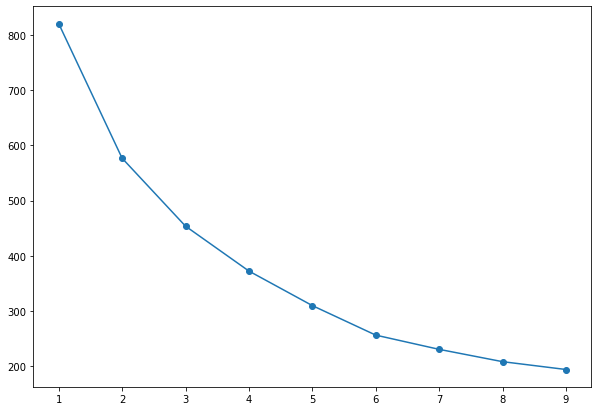

In [190]:
fig, ax = plt.subplots(figsize = (10,7))
plt.plot(range(1,10),wcss, marker ='o')
plt.show()

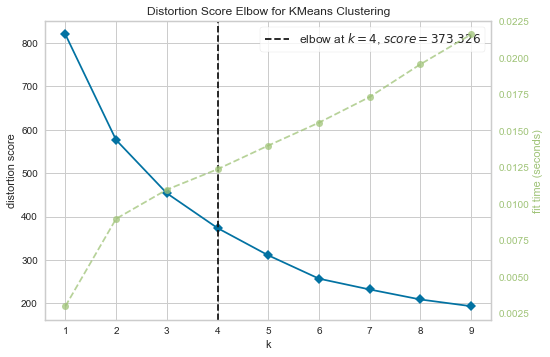

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [191]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10)).fit(rc_scaled_pca)
visualizer.show()

In [194]:
kmeans = KMeans(n_clusters=3, random_state = 42)
kmeans.fit_transform(rc_scaled_pca )
final_kmeans = pd.concat([pd.DataFrame(rc_scaled_pca), pd.DataFrame({'clusters' : kmeans.labels_})],axis = 1)
final_kmeans

,0,1,2,3,clusters
0,3.007140,-0.913723,-0.486887,0.164144,0
1,0.422689,-1.892573,-0.853308,0.053864,1
2,-0.720689,-1.817341,-1.274136,0.246680,1
3,0.047034,-0.060402,-1.813299,0.116474,1
4,0.346789,0.533374,-1.974560,0.001553,1
...,...,...,...,...,...
200,1.331717,2.477700,1.341169,0.213609,0
201,-1.278557,0.136446,1.545960,0.453393,2
202,-1.103696,-0.104117,1.719525,0.379654,2
203,1.410833,1.675227,1.694752,0.533056,0


In [195]:
# inverse the scaled data
rescaled = pd.DataFrame(sc.inverse_transform(rc_scaled))
rescaled
columns = rides_completed.columns.values
rescaled.columns=columns

In [196]:
clustered = pd.concat([rescaled,final_kmeans.clusters],axis=1)
clustered

,price,distance,tod(hr),year,clusters
0,3368.0,25.53,9.0,2022.0,0
1,1600.0,11.11,11.0,2022.0,1
2,1000.0,3.43,10.0,2022.0,1
3,1514.0,8.76,4.0,2022.0,1
4,1669.0,11.19,2.0,2022.0,1
...,...,...,...,...,...
200,2850.0,23.10,1.0,2017.0,0
201,1200.0,6.45,8.0,2017.0,2
202,1250.0,7.85,9.0,2017.0,2
203,3050.0,21.70,4.0,2017.0,0
